## System steup

In [29]:
from moleculekit.molecule import Molecule
import os
import importlib
from torchmdexp.losses.rmsd import rmsd
from torchmdexp.losses.tmscore import tm_score
from torchmdexp.samplers.utils import get_native_coords, get_embeddings
from moleculekit.projections.metricrmsd import MetricRmsd
from moleculekit.projections.metrictmscore import MetricTMscore
import numpy as np
import torch

device = "cuda:0"
precision = torch.float

In [30]:
domain = '1jfk'
ref_pdb = f'/workspace7/torchmd-AD/carles_cath/9b_good_train/1jfk/level_0/ground_truth/{domain}.pdb'
ref_psf = f'/workspace7/torchmd-AD/carles_cath/9b_good_topology/{domain}.psf'
#ref_xtc =  f'/workspace7/torchmd-AD/carles_cath/9b_good_xtc/{domain}_8kcenters.xtc'
#mol = Molecule(ref_xtc)
ref_mol = Molecule(ref_pdb)
ref_mol.filter('name CA')

mol = ref_mol
#mol.read(ref_psf)
ref_mol.read(ref_psf)

In [62]:
#mol.read(ref_xtc)

In [26]:
mol = Molecule('/shared/carles/repo/torchmd-exp/data/villin/villin_ca_top_dih.psf')
mol.read('/shared/carles/repo/torchmd-exp/data/villin/villin_kcenters_8clusters_coords.xtc')
ref_mol = Molecule('/shared/carles/repo/torchmd-exp/data/villin/villin_ca.pdb')

In [31]:
# Compute starting coords
#[mol.dropFrames(1) for _ in range(32)]

#mol.coords = np.expand_dims(mol.coords[:, : , ], axis=-1)
#mol.box = np.expand_dims(mol.box[:, 0], axis=-1)


native_coords = get_native_coords(ref_mol, device)
native_coords = native_coords.type(precision)
coords = get_native_coords(mol, device)
coords = coords.type(precision)


print('Starting rmsd: ', rmsd(coords, native_coords))

Starting rmsd:  tensor(0.0076, device='cuda:0')


In [32]:
tm_score(coords, native_coords)

tensor(1.0000, device='cuda:0')

In [33]:
from torchmd.forcefields.forcefield import ForceField
from torchmd.parameters import Parameters


ff = ForceField.create(mol, '/shared/carles/repo/torchmd-exp/data/ca_priors-dihedrals_general.yaml')
parameters = Parameters(ff, mol, precision=precision, device=device)

In [34]:
from torchmd.integrator import maxwell_boltzmann
from torchmd.systems import System

system = System(mol.numAtoms, nreplicas=1, precision=precision, device=device)
system.set_positions(mol.coords)
system.set_box(mol.box)
system.set_velocities(maxwell_boltzmann(parameters.masses, T=350, replicas=1))

In [35]:
system.pos

tensor([[[ 2.0730e+00,  0.0000e+00, -1.2450e+00],
         [ 4.2120e+00, -3.0510e+00, -5.8100e-01],
         [ 4.2400e+00, -4.3110e+00, -4.1500e+00],
         [ 4.2540e+00, -7.9700e-01, -5.5550e+00],
         [ 7.5600e+00, -5.3900e-01, -3.7300e+00],
         [ 8.9440e+00, -3.7610e+00, -5.1540e+00],
         [ 7.9780e+00, -2.7250e+00, -8.6630e+00],
         [ 9.0060e+00,  8.5200e-01, -7.9740e+00],
         [ 1.2541e+01, -7.9000e-02, -6.9920e+00],
         [ 1.2557e+01, -2.1730e+00, -1.0145e+01],
         [ 1.3320e+01,  8.0100e-01, -1.2357e+01],
         [ 1.3704e+01, -1.7230e+00, -1.5151e+01],
         [ 1.0001e+01, -2.3720e+00, -1.4709e+01],
         [ 9.9660e+00, -6.0940e+00, -1.5399e+01],
         [ 8.3910e+00, -7.5110e+00, -1.2263e+01],
         [ 1.1346e+01, -9.0280e+00, -1.0449e+01],
         [ 1.3974e+01, -8.0370e+00, -7.9120e+00],
         [ 1.7617e+01, -8.9470e+00, -7.4380e+00],
         [ 2.0175e+01, -9.1360e+00, -4.6540e+00],
         [ 2.1436e+01, -5.6520e+00, -5.4310e+00],


In [159]:
if torch.any(torch.isnan(system.pos)):
    raise RuntimeError("Found NaN coordinates.")

In [36]:
get_embeddings(mol, 'cpu', 1)

tensor([[15,  1,  6,  1, 20,  3, 19,  6, 21,  5, 14,  9,  2,  5,  2,  1, 14, 12,
          4,  6,  6, 14, 19,  1,  3, 14, 12, 19, 19, 18,  1, 21, 19,  9,  6, 10,
         20, 20, 10, 20, 21,  3, 19, 12, 21,  5,  1,  5,  2,  9,  2,  6, 21,  5,
         10,  9,  6,  3,  1, 19,  3,  4,  2, 12, 21, 10,  2, 10,  5, 20, 12,  5,
          5, 19, 21,  2, 20, 19, 14, 20,  4, 19, 20, 15,  5, 14,  5,  2,  5,  2,
         19, 20, 13, 19,  6,  6, 14, 13, 12,  3,  3, 19, 19, 11,  2, 21,  6, 19,
         14,  1,  6, 10, 14, 15, 19,  1,  5,  1,  9,  2,  5,  2,  4, 21, 13, 20,
          6,  6,  3, 20,  6,  3, 12, 20]])

In [37]:
externalmodule = importlib.import_module('torchmdnet.calculators')
nnp = '/shared/carles/repo/torchmd-exp/scripts/trainings/tests/test_cath/cath_1jfk/'
nnp += 'epoch=442-train_loss=0.6299-val_loss=0.9083.ckpt'
embeddings = torch.tensor([15,  1,  6,  1, 20,  3, 19,  6, 21,  5, 14,  9,  2,  5,  2,  1, 14, 12,
          4,  6,  6, 14, 19,  1,  3, 14, 12, 19, 19, 18,  1, 21, 19,  9,  6, 10,
         20, 20, 10, 20, 21,  3, 19, 12, 21,  5,  1,  5,  2,  9,  2,  6, 21,  5,
         10,  9,  6,  3,  1, 19,  3,  4,  2, 12, 21, 10,  2, 10,  5, 20, 12,  5,
          5, 19, 21,  2, 20, 19, 14, 20,  4, 19, 20, 15,  5, 14,  5,  2,  5,  2,
         19, 20, 13, 19,  6,  6, 14, 13, 12,  3,  3, 19, 19, 11,  2, 21,  6, 19,
         14,  1,  6, 10, 14, 15, 19,  1,  5,  1,  9,  2,  5,  2,  4, 21, 13, 20,
          6,  6,  3, 20,  6,  3, 12, 20]).repeat(1, 1)
external = externalmodule.External(nnp, embeddings, device)

In [38]:
print('Number of parameters nnp: ', sum(p.numel() for p in external.model.parameters() if p.requires_grad))

Number of parameters nnp:  294565


In [42]:
external.n_atoms

134

In [45]:
external.embeddings

tensor([15,  1,  6,  1, 20,  3, 19,  6, 21,  5, 14,  9,  2,  5,  2,  1, 14, 12,
         4,  6,  6, 14, 19,  1,  3, 14, 12, 19, 19, 18,  1, 21, 19,  9,  6, 10,
        20, 20, 10, 20, 21,  3, 19, 12, 21,  5,  1,  5,  2,  9,  2,  6, 21,  5,
        10,  9,  6,  3,  1, 19,  3,  4,  2, 12, 21, 10,  2, 10,  5, 20, 12,  5,
         5, 19, 21,  2, 20, 19, 14, 20,  4, 19, 20, 15,  5, 14,  5,  2,  5,  2,
        19, 20, 13, 19,  6,  6, 14, 13, 12,  3,  3, 19, 19, 11,  2, 21,  6, 19,
        14,  1,  6, 10, 14, 15, 19,  1,  5,  1,  9,  2,  5,  2,  4, 21, 13, 20,
         6,  6,  3, 20,  6,  3, 12, 20], device='cuda:0')

In [46]:
external.batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [48]:
type(external.model)

torchmdnet.models.model.TorchMD_Net

In [41]:
from torchmd.forces import Forces
#external=None
forces = Forces(parameters,terms=['bonds', 'repulsioncg', 'dihedrals'], cutoff=9, rfa=False, switch_dist=None, 
                external=external, exclusions = ('bonds')
               )
# Evaluate current energy and forces. Forces are modified in-place
import time
s = time.perf_counter()
Epot = forces.compute(system.pos, system.box, system.forces, returnDetails=False)
e = time.perf_counter()
print(e-s)
print(Epot)
print(system.forces)

0.04622808285057545
[-235.68578910827637]
tensor([[[ -2.9406,   4.0569,  -0.5350],
         [  3.6468,  -0.4237,  11.3497],
         [ -1.2936, -12.9705,  -7.8306],
         [ -4.3988,   6.5761,  -7.6697],
         [  2.4734,   9.0002,   9.3337],
         [  7.0732,  -9.6322,   4.5858],
         [ -6.9730,  -8.3132,  -9.2301],
         [ -7.6354,  13.8089,  -3.4669],
         [ 12.0085,   1.9848,  13.5041],
         [  0.5383, -13.3350,  -2.3912],
         [  0.6525,  14.0728,   4.1595],
         [  9.2528,  -7.4552,  -9.3267],
         [-11.9150,   1.6529,   0.3210],
         [  7.4292,   1.3619,  -9.0331],
         [ -8.3190,  -2.9649,   7.9740],
         [ -5.2835,   0.5948,  -9.4335],
         [ -2.1087,   6.2112,   4.8913],
         [  6.9397,  10.7717,  -2.4075],
         [  2.0383, -12.2164,   9.3420],
         [ 16.2044,   7.3663,  -3.1472],
         [ -9.2196,  10.5131,  -9.6722],
         [-13.3469, -10.7564,   4.8148],
         [  9.6355,  -6.0173,  12.8317],
         [  5.8

## Dynamics

In [165]:
from torchmd.integrator import Integrator
from torchmd.wrapper import Wrapper

langevin_temperature = 350  # K
langevin_gamma = 1
timestep = 5  # fs

integrator = Integrator(system, forces, timestep, device, gamma=langevin_gamma, T=langevin_temperature)
wrapper = Wrapper(mol.numAtoms, mol.bonds if len(mol.bonds) else None, device)


In [166]:
from torchmd.minimizers import minimize_bfgs

print(rmsd(system.pos, native_coords))
#minimize_bfgs(system, forces, steps=500)  # Minimize the system
print(rmsd(system.pos, native_coords))

tensor(0.0076, device='cuda:0')
tensor(0.0076, device='cuda:0')


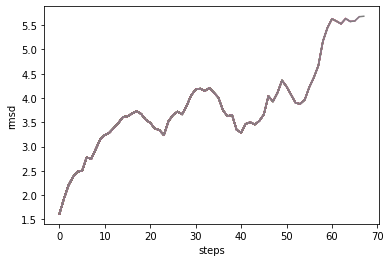

  7%|██▊                                      | 68/1000 [04:14<58:06,  3.74s/it]


KeyboardInterrupt: 

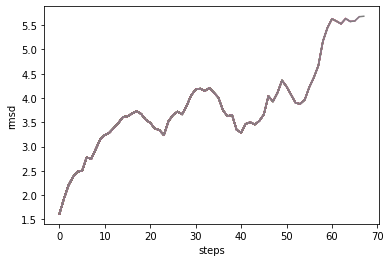

In [167]:
from tqdm import tqdm 
import numpy as np
%matplotlib inline
import time
import pylab as pl
from IPython import display

FS2NS = 1E-6 # Femtosecond to nanosecond conversion

steps = 100000
output_period = 100
save_period = 10
traj = []

trajectoryout = "mytrajectory.npy"

iterator = tqdm(range(1, int(steps / output_period) + 1))
Epot = forces.compute(system.pos, system.box, system.forces)
rmsds = []
Ep = []
tm_scores = []
for i in iterator:
    Ekin, Epot, T = integrator.step(niter=output_period)
    rmsds.append(rmsd(system.pos, native_coords).item())
    tm_scores.append(tm_score(system.pos, native_coords).item())
    Ep.append(Epot)

    pl.plot(rmsds)
    pl.xlabel('steps')
    pl.ylabel('rmsd')
    
    display.clear_output(wait=True)
    display.display(pl.gcf())

In [168]:
print(rmsds)

[1.6132532358169556, 1.9259135723114014, 2.201615333557129, 2.375335454940796, 2.4843039512634277, 2.501485586166382, 2.777698278427124, 2.7449889183044434, 2.948359489440918, 3.1475982666015625, 3.2390401363372803, 3.28770112991333, 3.384751081466675, 3.4872803688049316, 3.611292839050293, 3.6234993934631348, 3.6813559532165527, 3.7287113666534424, 3.6717004776000977, 3.553842306137085, 3.488402843475342, 3.372314691543579, 3.3401739597320557, 3.235546350479126, 3.5202794075012207, 3.650254726409912, 3.7202658653259277, 3.6641829013824463, 3.8383028507232666, 4.0552473068237305, 4.176267147064209, 4.193631172180176, 4.145183086395264, 4.207592487335205, 4.111751556396484, 4.008963584899902, 3.74760103225708, 3.626075506210327, 3.652721405029297, 3.3464107513427734, 3.2862889766693115, 3.466989755630493, 3.5013537406921387, 3.454789876937866, 3.5281028747558594, 3.6608211994171143, 4.040021896362305, 3.9296698570251465, 4.108778953552246, 4.361713409423828, 4.236106872558594, 4.0665183

In [169]:
print(tm_scores)

[0.8869118690490723, 0.8492711782455444, 0.8160679340362549, 0.7929492592811584, 0.7808713316917419, 0.780775785446167, 0.7501221895217896, 0.7608454823493958, 0.7402265071868896, 0.7114847302436829, 0.6997596025466919, 0.6944248080253601, 0.6766287088394165, 0.6622248888015747, 0.6609970331192017, 0.6604514718055725, 0.6528819799423218, 0.6565775871276855, 0.6517940759658813, 0.6680573225021362, 0.6905807852745056, 0.6983417272567749, 0.6879599094390869, 0.703145444393158, 0.6699679493904114, 0.6554152965545654, 0.6509443521499634, 0.6580794453620911, 0.6558791995048523, 0.6262921094894409, 0.6056808829307556, 0.5952492356300354, 0.6028037667274475, 0.590187668800354, 0.608081042766571, 0.618205189704895, 0.6484229564666748, 0.6630153656005859, 0.6523056030273438, 0.6957499980926514, 0.7027231454849243, 0.672838032245636, 0.6672454476356506, 0.6649703979492188, 0.6809380054473877, 0.668816328048706, 0.6151344776153564, 0.6420786380767822, 0.6433913707733154, 0.6265550255775452, 0.6354

In [56]:
#pos_xtc = start_pos.detach().cpu().numpy().copy()
#mol.coords = np.moveaxis(pos_xtc, 0, -1)
#mol.write(f'/workspace7/torchmd-AD/carles_cath/9b_good_xtc/{domain}.pdb')

In [57]:
#mol.box = np.array([39.972, 39.941, 39.935], dtype=np.float32)

Text(0, 0.5, 'rmsd')

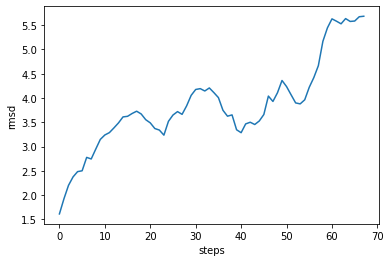

In [170]:
pl.plot(rmsds)
pl.xlabel('steps')
pl.ylabel('rmsd')

Text(0, 0.5, 'E')

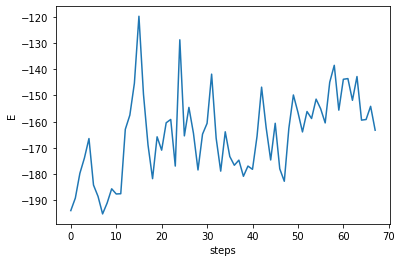

In [171]:
pl.plot(Ep)
pl.xlabel('steps')
pl.ylabel('E')

Text(0, 0.5, 'E')

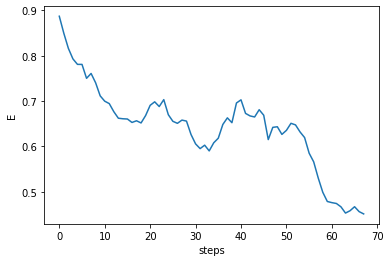

In [172]:
pl.plot(tm_scores)
pl.xlabel('steps')
pl.ylabel('E')